In [1]:
import pandas as pd
import codecs
import re
from math import log
import time
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
import seaborn as sns
from spacy.util import minibatch
import spacy
from joblib import dump
from collections import Counter
import collections
import pickle
import itertools

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import nltk

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix

###  Preproccessing
Load in our datasets and perform some pre-processing, including removing duplicates, merging spam and non-spam datasets once converted to pandas dataframes, and the data is shuffled. Then a train-test-split is performed giving 70% training, and a 30% test 

In [2]:
#load in the data and transform into a oandas dataset and define the columns for the non-spam(ham) file
pathHam = 'C:\\Users\\irene\\Downloads\\enron1\\ham\\*.txt'
fileListHam = glob.glob(pathHam)
list_Ham = []

for fileHam in fileListHam:
    with open(fileHam) as file:
        list_Ham.append(file.read())
        
ham=pd.DataFrame(list_Ham, columns=["emails"])
ham["target"]=0

In [3]:
##check for duplicates and drop if necessary, keep laast so it doesn't auto remove last row
ham.drop_duplicates(keep="last")

,emails,target
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0
5,"Subject: mcmullen gas for 11 / 99\njackie ,\ns...",0
...,...,...
3667,Subject: re : tenaska iv\ni ' ll call you on t...,0
3668,"Subject: generic contract\nhi daren ,\nsorry f...",0
3669,Subject: re : contracts and credit\nthanks - -...,0
3670,"Subject: re : tenaska iv\nok , since we don ' ...",0


In [4]:
ham.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emails  3673 non-null   object
 1   target  3673 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.5+ KB


In [5]:
#view ham dataset top 5 to chack data is looking okay
ham.head()

,emails,target
0,Subject: christmas tree farm pictures\n,0
1,"Subject: vastar resources , inc .\ngary , prod...",0
2,Subject: calpine daily gas nomination\n- calpi...,0
3,Subject: re : issue\nfyi - see note below - al...,0
4,Subject: meter 7268 nov allocation\nfyi .\n- -...,0


In [6]:
##load in the data and transform into a oandas dataset and define the columns for the spam file
pathSpam = 'C:\\Users\\irene\\Downloads\\enron1\\spam\\*.txt'
fileListSpam = glob.glob(pathSpam)
list_Spam = []

for fileSpam in fileListSpam:
    with open(fileSpam, encoding="Latin-1") as f:
        list_Spam.append(f.read())
        
spam=pd.DataFrame(list_Spam, columns=["emails"])
spam["target"]=1

In [7]:
#view spam dataset top 5 to chack data is looking okay
spam.head()

,emails,target
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434\npeople nowthe ...,1
3,"Subject: await your response\ndear partner ,\n...",1
4,"Subject: coca cola , mbna america , nascar par...",1


In [8]:
spam.drop_duplicates(keep="last")

,emails,target
0,Subject: dobmeos with hgh my energy level has ...,1
1,Subject: your prescription is ready . . oxwq s...,1
2,Subject: get that new car 8434\npeople nowthe ...,1
3,"Subject: await your response\ndear partner ,\n...",1
4,"Subject: coca cola , mbna america , nascar par...",1
...,...,...
1495,Subject: our pro - forma invoice attached\ndiv...,1
1496,Subject: str _ rndlen ( 2 - 4 ) } { extra _ ti...,1
1497,Subject: check me out !\n61 bb\nhey derm\nbbbb...,1
1498,Subject: hot jobs\nglobal marketing specialtie...,1


In [9]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   emails  1500 non-null   object
 1   target  1500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.6+ KB


In [10]:
#combine the spam and ham datasets into one combined dataset using pandas concantenate
emailCom = pd.concat([ham,spam])
# shuffle rows 
emailCom = emailCom.sample(frac=1).reset_index(drop=True)

In [11]:
#chack the combined has both spam and non-spam emails
emailCom

,emails,target
0,Subject: cute gals seeking love\nfinally a pla...,1
1,Subject: lst rev mar . 2000 josey ranch nom\n-...,0
2,Subject: meter 981594 - san jacinto low pressu...,0
3,Subject: duke cashout entries 5 / 00 and 6 / 0...,0
4,Subject: v - i - a - g - r - a is lousy ? ? ? ...,1
...,...,...
5168,Subject: updated for october\nhere ya go . if ...,0
5169,Subject: re : noms / actual vols for may lst\n...,0
5170,Subject: fw : on call\n- - - - - original mess...,0
5171,Subject: i will be out next week\nimbalances :...,0


### Train Test Split
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split

In [12]:
#perfrom the train test split 70% train and 30% test, random state for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(emailCom['emails'],emailCom['target'], train_size= .7, random_state = 862)

In [13]:
Y_train

2311    0
1023    1
3263    0
4395    0
1268    1
       ..
4968    0
3929    1
160     0
3749    0
172     0
Name: target, Length: 3621, dtype: int64

In [14]:
# create a combined dataset of the training data 
training = pd.concat([X_train, Y_train], axis=1)
training.to_csv("training.csv", sep='\t', encoding='utf-8', index=True)

In [15]:
#view combined traing data
training

,emails,target
2311,Subject: final cp name change and merger repor...,0
1023,Subject: russian girls sex ! only teens !\nhi ...,1
3263,"Subject: hpl nom for june 7 , 2000\n( see atta...",0
4395,Subject: re : ua 4\nwhat is the status on this...,0
1268,Subject: cfp : int . conf . on web delivering ...,1
...,...,...
4968,"Subject: re : 98 - 1601\njanet ,\n. 16 decathe...",0
3929,Subject: [ 89 ] security warning ! [ 18 ]\nput...,1
160,Subject: calpine daily and monthly nomination\...,0
3749,Subject: feb 01 prod : sale to teco gas proces...,0


In [16]:
#combined test dataset
testing = pd.concat([X_test,Y_test], axis=1)
testing.to_csv('testing.csv', sep='\t',encoding='utf-8',index=False)

In [17]:
#view data
testing

,emails,target
2020,Subject: hpl nomination for 02 / 23 / 2000\nse...,0
3010,Subject: resume - anna cola\nanna cola is thro...,0
2598,Subject: team room\n- - - - - - - - - - - - - ...,0
1757,Subject: calpine daily and monthly gas nominat...,0
3264,Subject: 9 th noms\n- - - - - - - - - - - - - ...,0
...,...,...
3687,Subject: tenaska 2 / 01\nwe need to forward th...,0
339,Subject: enron net works\nit is becoming incre...,0
133,Subject: rockets schedule\nthe schedule is att...,0
2602,"Subject: lagrangian\nchaney , !\n75 % off for ...",1


In [94]:
#look for null values
np.where(pd.isnull(emailCom))
#look for empty cells in the email column
np.where(emailCom.applymap(lambda x: x ==""))

(array([], dtype=int64), array([], dtype=int64))

In [20]:
#chaeck data is split correctly
# is 70 percent
X_train.size

3621

In [21]:
X_test.size #is 30 percent

1552

In [22]:
Y_test.mean() # 29% spam, 71% ham

0.2925257731958763

In [23]:
Y_train.head()  #same again

2311    0
1023    1
3263    0
4395    0
1268    1
Name: target, dtype: int64

In [24]:
emailCom.head()

,emails,target
0,Subject: cute gals seeking love\nfinally a pla...,1
1,Subject: lst rev mar . 2000 josey ranch nom\n-...,0
2,Subject: meter 981594 - san jacinto low pressu...,0
3,Subject: duke cashout entries 5 / 00 and 6 / 0...,0
4,Subject: v - i - a - g - r - a is lousy ? ? ? ...,1


In [25]:
#isolate the spam emails 
allSpam = ' '.join(training[training['target']==1]['emails'])

https://www.datacamp.com/community/tutorials/wordcloud-python
word cloud source

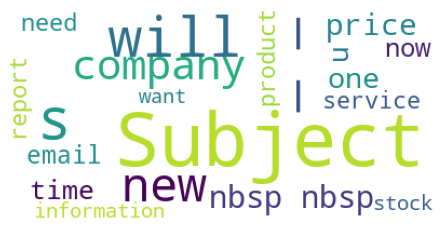

In [26]:
#wordcloud of top 20 spam words pre- stop word implementation
spamfig = WordCloud(max_font_size=70, max_words=20, background_color="white").generate(allSpam)
plt.figure()
plt.imshow(spamfig)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

The first step in feature extraction is the use of stop words to allow for removal of frequent words that woulkd be likely to appear in both spam and non-spam emails, this includes words like subject, email style farewells and deashes, etc.
the Lemmatize function is used to change all words to lower case so they aren't counted in their different forms.
Tokenizer is used to split emails into  individual words and emove punctuationn.
These functions are used on both test and train files, and thge test file is retained until the end.
From the sk.learn package TFIDF Bag of words and Bag Of Words. bag of words measures the occurance of words, and Tfidf creates a set of vecotrs containing count of word occurances, and mesures how relevant a word is to the selected email in the collection. this is done by multiplying "times word appears" by "inverse document frequency across the dataset"

In [27]:
#set stop words function, remove words/symbols/stray letters which are common
#displays list of removed words
#waste of space to print but there if necessery, it will be ### out in the report
sw = set(stopwords.words('english'))
newStopWords = (['subject','email','looking','yours','regards','best','-', '_','u','a','e','kind','www'])
sws =sw.union(newStopWords)
#print(sws)

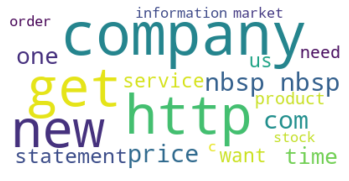

In [28]:
#spam wordcloud with stop words implemented, stopwords= sws
spamfigclean = WordCloud(stopwords=sws, max_font_size = 70,  max_words=20, background_color="white").generate(allSpam)
plt.figure()
plt.imshow(spamfigclean, interpolation='bilinear')
plt.axis('off')
plt.show()

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/ - for lemmatize
https://www.nltk.org/_modules/nltk/tokenize/regexp.html - for Tokenization

In [95]:
#perform on both trian and test
lowerCase= WordNetLemmatizer()
tokentext = RegexpTokenizer(r'\w+')

def lematize(text):
    return [lowerCase.lemmatize(w) for w in tokentext.tokenize(text)]

X_train_lowerCase = X_train.apply(lematize)
X_train_clean = X_train_lowerCase.apply(lambda x: ' '.join([word for word in x if word.lower() not in sws]))

X_test_lowerCase = X_test.apply(lematize)
X_test_clean = X_test_lowerCase.apply(lambda x: ' '.join([word for word in x if word.lower() not in sws]))

In [30]:
#check X_trian_clean afetr processing above
X_train_clean.head()

2311    final cp name change merger report 08 00 clari...
1023    russian girl sex teen hi jody young russian te...
3263    hpl nom june 7 2000 see attached file hplo 607...
4395    ua 4 status meter howard b camp 01 28 2000 07 ...
1268    cfp int conf web delivering music wedelmusic 2...
Name: emails, dtype: object

In [91]:
#create another pandas dataset
train_clean = pd.concat([X_train_clean, Y_train],axis=1)
train_clean.columns = ['emails','target']

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html 

In [32]:
#countVectorizer assigns an identifier to each word
vectorGrp = CountVectorizer(min_df=5, ngram_range=(1,2), analyzer='char_wb')
Xvec_word = vectorGrp.fit_transform(np.array(X_train_clean))
Xvec_word.shape

(3621, 891)

In [33]:
#convert from array to matrix
#rows = number of emails 
#columns= ids mentioned prior
matrixGrp = Xvec_word.toarray()
print(matrixGrp)

[[84  2  0 ...  0  0  0]
 [84  0  0 ...  0  0  0]
 [28  0  0 ...  0  0  0]
 ...
 [68  0  1 ...  0  0  0]
 [84  4  1 ...  0  0  0]
 [76  2  2 ...  0  0  0]]


In [34]:
#get the shape of new matrix
matrixGrp.shape

(3621, 891)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [35]:
#tf-idf converts raw data to matrix of equations
#converted to np.array to give shape to the transformed document
transformVec = TfidfVectorizer(min_df=5, ngram_range= (1,2), analyzer= 'char_wb')
XVecTransform = transformVec.fit_transform(X_train_clean)

NN = np.array(transformVec.get_feature_names())
sort_vec = XVecTransform.max(0).toarray()[0].argsort()

In [36]:
VecF = XVecTransform.toarray()
print(VecF)

[[0.75901988 0.02922309 0.         ... 0.         0.         0.        ]
 [0.77612243 0.         0.         ... 0.         0.         0.        ]
 [0.75316978 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.75194906 0.         0.0161769  ... 0.         0.         0.        ]
 [0.79382918 0.06112657 0.01382495 ... 0.         0.         0.        ]
 [0.77911273 0.03315423 0.02999386 ... 0.         0.         0.        ]]


In [37]:
train_clean.head()

,emails,target
2311,final cp name change merger report 08 00 clari...,0
1023,russian girl sex teen hi jody young russian te...,1
3263,hpl nom june 7 2000 see attached file hplo 607...,0
4395,ua 4 status meter howard b camp 01 28 2000 07 ...,0
1268,cfp int conf web delivering music wedelmusic 2...,1


## Exploratory Data Analysis (EDA)
We look at diiferent aspeact of the cleansed data, including top 20 words pre and post cleaning, a boxplot to see which emails have longer lengths and where the longest email is located

<AxesSubplot:xlabel='Word'>

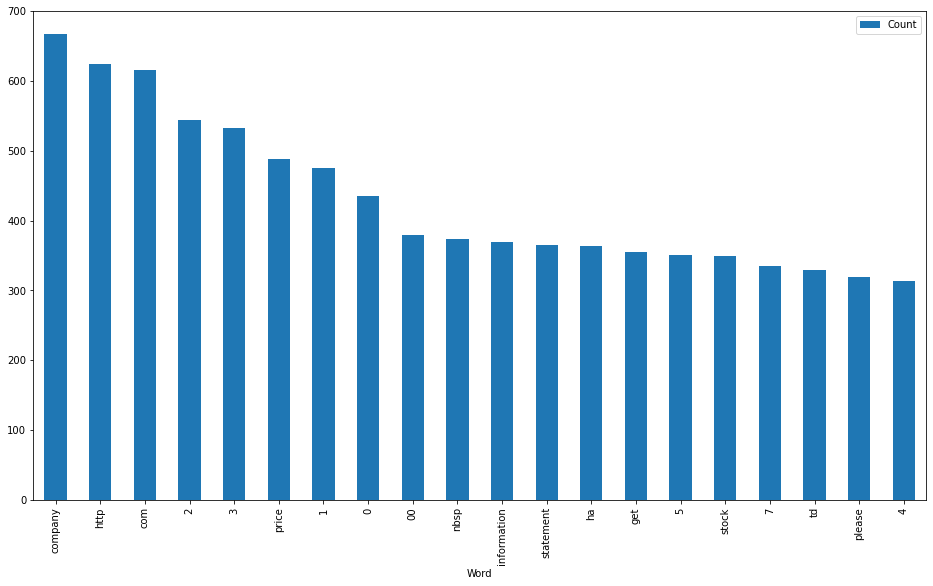

In [39]:
spamTotal = ' '.join(train_clean[train_clean['target']==1]['emails'])
spamT20 = collections.Counter(spamTotal.split()).most_common(20)
spam20=pd.DataFrame(spamT20, columns = ['Word', 'Count'])
plt.xticks
plt.rcParams['figure.figsize'] = 16,9
spam20.plot.bar(x='Word',y='Count')

In [40]:
#top 10 spam words
spam20.head(10)

,Word,Count
0,company,667
1,http,624
2,com,616
3,2,544
4,3,532
5,price,488
6,1,476
7,0,435
8,00,379
9,nbsp,373


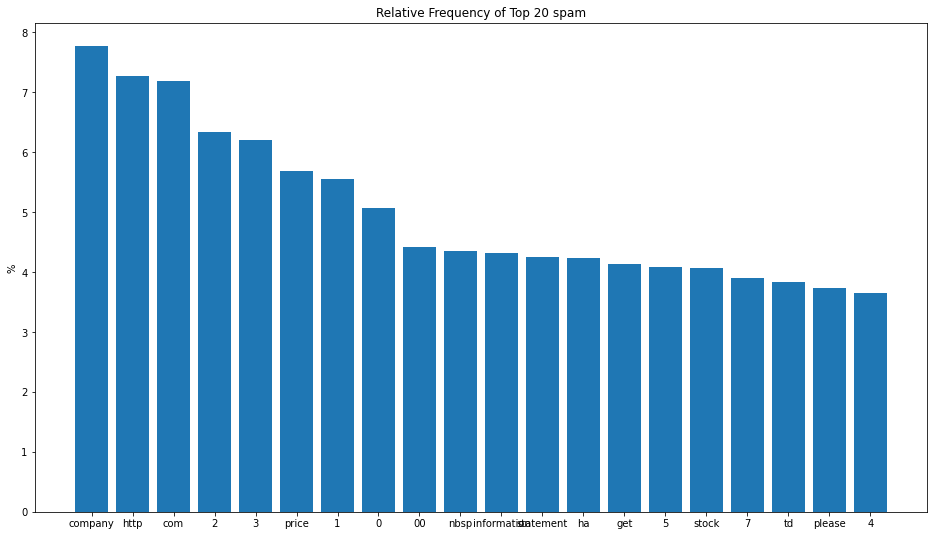

In [41]:
seriesChange = spam20['Count']/sum(spam20['Count'])
indxRng = range(20)
plt.bar(indxRng, seriesChange*100)
plt.ylabel('%')
plt.title('Relative Frequency of Top 20 spam')
plt.xticks(indxRng,spam20['Word'])
figsize=(16,9)

<AxesSubplot:xlabel='Word'>

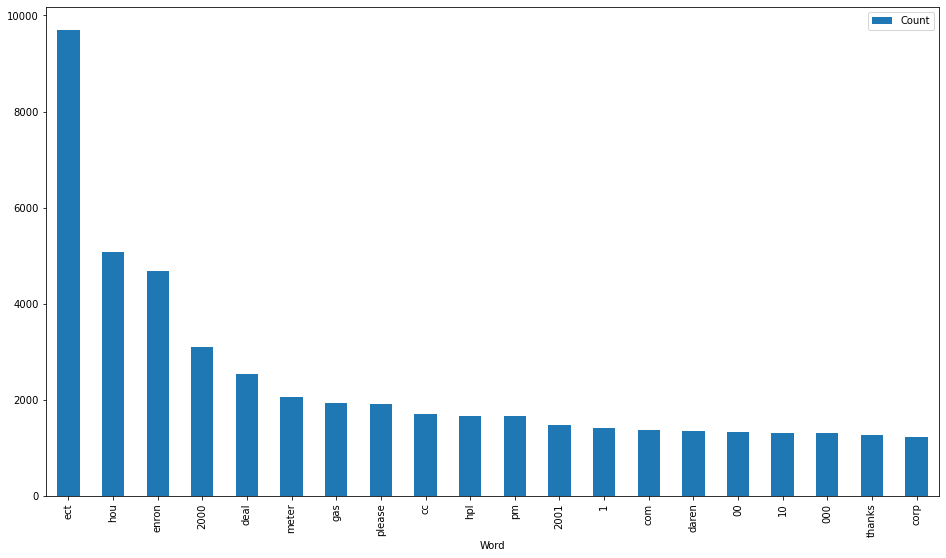

In [42]:
#bar chart of most frequently used words vs word count for non-spam
hamTotal = ' '.join(train_clean[train_clean['target']==0]['emails'])
hamT20 = collections.Counter(hamTotal.split()).most_common(20)
ham20=pd.DataFrame(hamT20, columns = ['Word', 'Count'])
plt.rcParams['figure.figsize'] = 16,9
ham20.plot.bar(x='Word',y='Count')

In [43]:
#view non-spam top 10 words
ham20.head(10)

,Word,Count
0,ect,9694
1,hou,5086
2,enron,4678
3,2000,3110
4,deal,2539
5,meter,2057
6,gas,1936
7,please,1911
8,cc,1708
9,hpl,1667


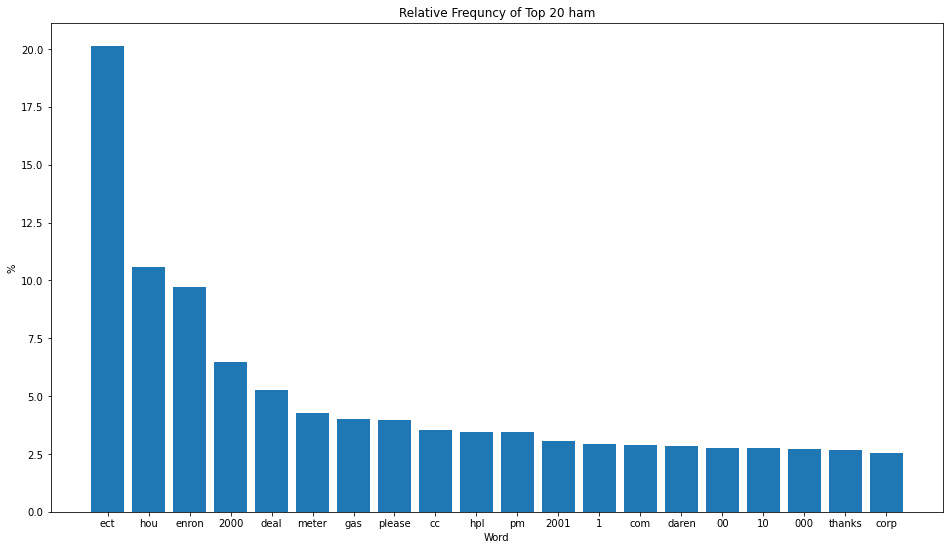

In [44]:
#frequency bar chart of the top 20 non-spam words
seriesChange1 = ham20['Count']/sum(ham20['Count'])
indxRng1 = range(20)
plt.bar(indxRng1, seriesChange1*100)
plt.xlabel("Word")
plt.ylabel('%')
plt.title('Relative Frequncy of Top 20 ham')
plt.xticks(indxRng1,ham20['Word'])
figsize=(16,9)

In [45]:
#add in email length (for visualisation) and class (for convenience)
#will make graphs look better
train_clean['length']=train_clean['emails'].str.len()
terms = [train_clean['target']==1,train_clean['target']==0]
out = ['Spam','NonSpam']
train_clean['Class'] = np.select(terms, out)
train_clean.head()

,emails,target,length,Class
2311,final cp name change merger report 08 00 clari...,0,264,NonSpam
1023,russian girl sex teen hi jody young russian te...,1,242,Spam
3263,hpl nom june 7 2000 see attached file hplo 607...,0,61,NonSpam
4395,ua 4 status meter howard b camp 01 28 2000 07 ...,0,739,NonSpam
1268,cfp int conf web delivering music wedelmusic 2...,1,5323,Spam


max length around 21,000 in the spam class
this is a major outlier compared to every other data point in both classes
boxplot of email length separated by class

(0.0, 25000.0)

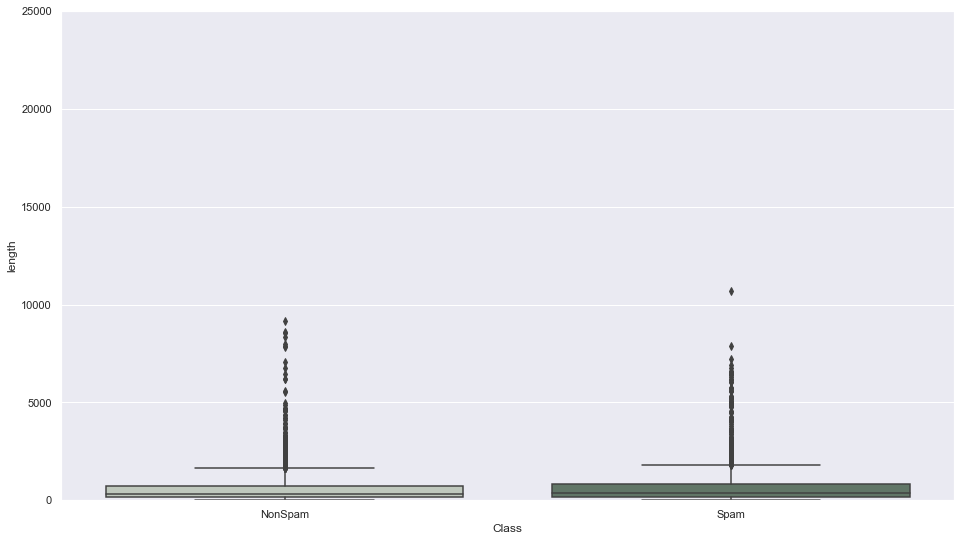

In [46]:
#using seaborn package
sns.set(context='notebook', style='darkgrid')
figsize = (10,10)
boxP = sns.boxplot(x='Class',y='length', palette='Greens', saturation = 0.2, data=train_clean)
boxP.set_ylim([0,25000])

(0.0, 2000.0)

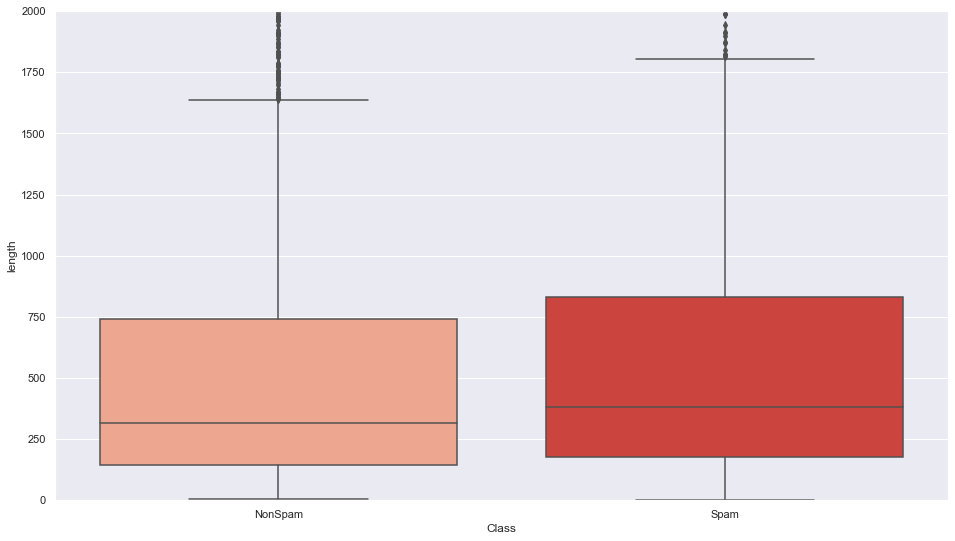

In [47]:
#a close up of the boxplot shown above, spam email has an average longer length
sns.set(context='notebook', style='darkgrid')
figsize = (12,9)
boxP = sns.boxplot(x='Class',y='length', palette= "Reds",data= train_clean)
boxP.set_ylim([0,2000])

In [48]:
#longest email is spam
train_clean[train_clean['length']==train_clean['length'].max()]

,emails,target,length,Class
4260,got info internet hope cooperate html head tit...,1,10702,Spam


In [93]:
#compute 5 most common words from longest email
long = train_clean.loc[4260,'emails']
collections.Counter(long.split()).most_common(5)

[('font', 177), ('height', 146), ('pt', 138), ('td', 128), ('style', 84)]

### Supervised Classification
Here we look at different types of classifications models multinomial naive bayes, logistic regression, and random forest. we will check the accuracy of the f1 score of each model, while applying count vectorizer and tfidf vectorizer to each model separately to fin the model with the highest accuracy.
A validation train test is apploed to the current train_clean dataframe in other to perform a validation on our models.

In [50]:
#create a train test split for the purpose of cross validation 
X_train_2, X_val, Y_train_2, Y_val = train_test_split(train_clean['emails'], train_clean['target'], train_size=.71, random_state=862)

In [51]:
#perform some EDA
#check parameters are correct
X_train_2[1:5]

1916    expatriate zone issue 1 2 14 00 expatriate zon...
972     hpl nom march 29 2001 see attached file hplno ...
989     big cowboy august mary issue confirmed volume ...
4924    investor toolbox mcintyre iogn get explode chr...
Name: emails, dtype: object

In [52]:
X_train.describe()

count                                                  3621
unique                                                 3528
top       Subject: calpine daily gas nomination\n>\nrick...
freq                                                     17
Name: emails, dtype: object

In [53]:
X_train_2.describe()

count     2570
unique    2503
top           
freq        13
Name: emails, dtype: object

In [54]:
X_train_2.size

2570

In [55]:
X_val.describe()

count                                                  1051
unique                                                 1034
top       calpine daily gas nomination ricky archer fuel...
freq                                                      8
Name: emails, dtype: object

In [56]:
Y_train_2.size

2570

In [57]:
Y_val.size

1051

https://www.datacamp.com/community/tutorials/scikit-learn-fake-news

In [58]:
#a function for creating good looking confusion matrices
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [59]:
#the data is now trained as Multinomial bayes model
##multinomial bayes model using count vectorizer
bag_of_w_vec = CountVectorizer().fit(X_train_2)
train2Vec = bag_of_w_vec.transform(X_train_2)
MB_bow = MultinomialNB(alpha=0.1)
MB_bow.fit(train2Vec,Y_train_2)
y_pred = MB_bow.predict(train2Vec)
X_bow_val = bag_of_w_vec.transform(X_val)
y_val_model = MB_bow.predict(X_bow_val)

In [60]:
y_pred.size

2570

In [61]:
y_val_model.size

1051

In [62]:
X_val.size

1051

In [63]:
print(confusion_matrix(Y_val, y_val_model))

[[760   9]
 [  7 275]]


Confusion matrix, without normalization


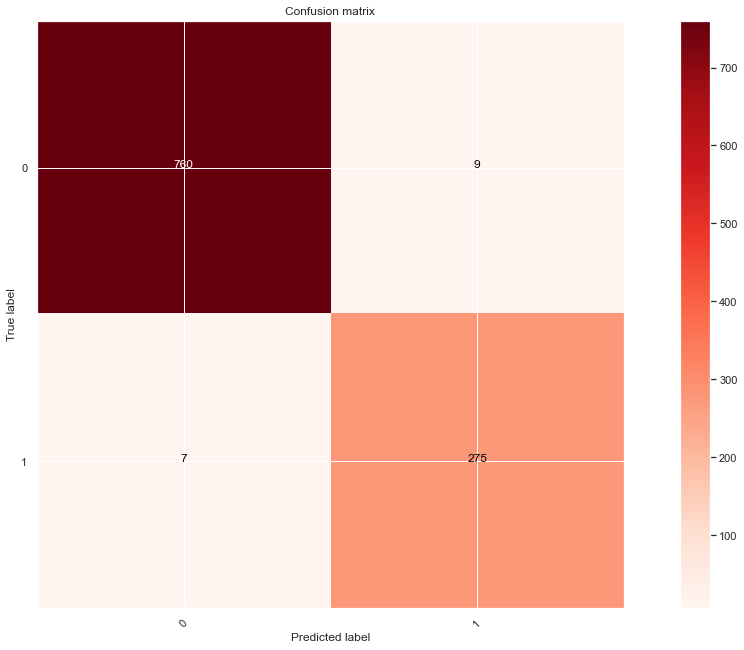

In [64]:
#visualised confusion matrix, the rest will look similar to avove to save on space but this can be 
#applied to each confusion matrix
cm = metrics.confusion_matrix(Y_val, y_val_model, labels=[0,1])
plot_confusion_matrix(cm, classes = [0,1])

In [65]:
#classification reort of MNB using count vectorizer
print(classification_report(Y_val, y_val_model, digits= 4))

              precision    recall  f1-score   support

           0     0.9909    0.9883    0.9896       769
           1     0.9683    0.9752    0.9717       282

    accuracy                         0.9848      1051
   macro avg     0.9796    0.9817    0.9807      1051
weighted avg     0.9848    0.9848    0.9848      1051



In [66]:
pickle.dump(MB_bow, open('MB_count.sav', 'wb'))

In [67]:
#multinomial bayes model using tfidf vectoizer
tf_vector = TfidfVectorizer().fit(X_train_2)
Xtrain_tfidf = tf_vector.transform(X_train_2)
tfBayes = MultinomialNB(alpha=0.1)
tfBayes.fit(Xtrain_tfidf, Y_train_2)
ytrain_tfidf_pred = tfBayes.predict(Xtrain_tfidf)
Xval_tfidf = tf_vector.transform(X_val)
yval_tfidf = tfBayes.predict(Xval_tfidf)

In [68]:
print(confusion_matrix(Y_val, yval_tfidf))

[[763   6]
 [ 15 267]]


In [69]:
#cm = metrics.confusion_matrix(Y_val, yval_tfidf, labels=[0,1])
#plot_confusion_matrix(cm, classes = [0,1])

In [70]:
#classification reort of MNB using tfidf vectorizer
print(classification_report(Y_val, yval_tfidf, digits= 4))

              precision    recall  f1-score   support

           0     0.9807    0.9922    0.9864       769
           1     0.9780    0.9468    0.9622       282

    accuracy                         0.9800      1051
   macro avg     0.9794    0.9695    0.9743      1051
weighted avg     0.9800    0.9800    0.9799      1051



In [71]:
pickle.dump(tfBayes, open('MB_tfidf.sav', 'wb'))

In [72]:
##linear regression model using count vectorizer
lr1 = CountVectorizer().fit(X_train_2)
lr2 = lr1.transform(X_train_2)

lr3 = LogisticRegression()
lr3.fit(lr2, Y_train_2)
lr4 = lr3.predict(lr2)

lr5 = lr1.transform(X_val)
lr6 = lr3.predict(lr5)

In [73]:
print(confusion_matrix(Y_val, lr6))

[[752  17]
 [ 11 271]]


In [74]:
#cm = metrics.confusion_matrix(Y_val, lr6, labels=[1,0])
#plot_confusion_matrix(cm, classes = [1,0])

In [75]:
#classification reort of LR using count vectorizer
print(classification_report(Y_val, lr6, digits= 4))

              precision    recall  f1-score   support

           0     0.9856    0.9779    0.9817       769
           1     0.9410    0.9610    0.9509       282

    accuracy                         0.9734      1051
   macro avg     0.9633    0.9694    0.9663      1051
weighted avg     0.9736    0.9734    0.9734      1051



In [76]:
pickle.dump(lr3, open('LR_count.sav', 'wb'))

In [77]:
#linear regression model using tfidf vectorizer
lrf1 = TfidfVectorizer().fit(X_train_2)
lrf2 = tf_vector.transform(X_train_2)

lrf3 = LogisticRegression()
lrf3.fit(lrf2, Y_train_2)
lrf4 = lrf3.predict(lrf2)

lrf5 = lrf1.transform(X_val)
lrf6 = lrf3.predict(lrf5)

In [78]:
#classification reort of LR using tfidf vectorizer
print(classification_report(Y_val, lrf6, digits= 4))

              precision    recall  f1-score   support

           0     0.9909    0.9870    0.9889       769
           1     0.9649    0.9752    0.9700       282

    accuracy                         0.9838      1051
   macro avg     0.9779    0.9811    0.9795      1051
weighted avg     0.9839    0.9838    0.9839      1051



In [79]:
#cm = metrics.confusion_matrix(Y_val, lrf6, labels=[1,0])
#plot_confusion_matrix(cm, classes = [1,0])

In [80]:
pickle.dump(lrf3, open('LR_tfidf.sav', 'wb'))

In [81]:
#random forest using count vectorizer model
rf1 = CountVectorizer().fit(X_train_2)
rf2 = rf1.transform(X_train_2)

rf3 = RFC()
rf3.fit(rf2, Y_train_2)
rf4 = rf3.predict(rf2)

rf5 = rf1.transform(X_val)
rf6 = rf3.predict(rf5)

In [82]:
#classification reort of RF using count vectorizer
print(classification_report(Y_val, rf6, digits= 4))

              precision    recall  f1-score   support

           0     0.9855    0.9727    0.9791       769
           1     0.9281    0.9610    0.9443       282

    accuracy                         0.9696      1051
   macro avg     0.9568    0.9668    0.9617      1051
weighted avg     0.9701    0.9696    0.9697      1051



In [83]:
#cm = metrics.confusion_matrix(Y_val, rf6, labels=[1,0])
#plot_confusion_matrix(cm, classes = [1,0])

In [84]:
pickle.dump(rf3, open('RF_count.sav', 'wb'))

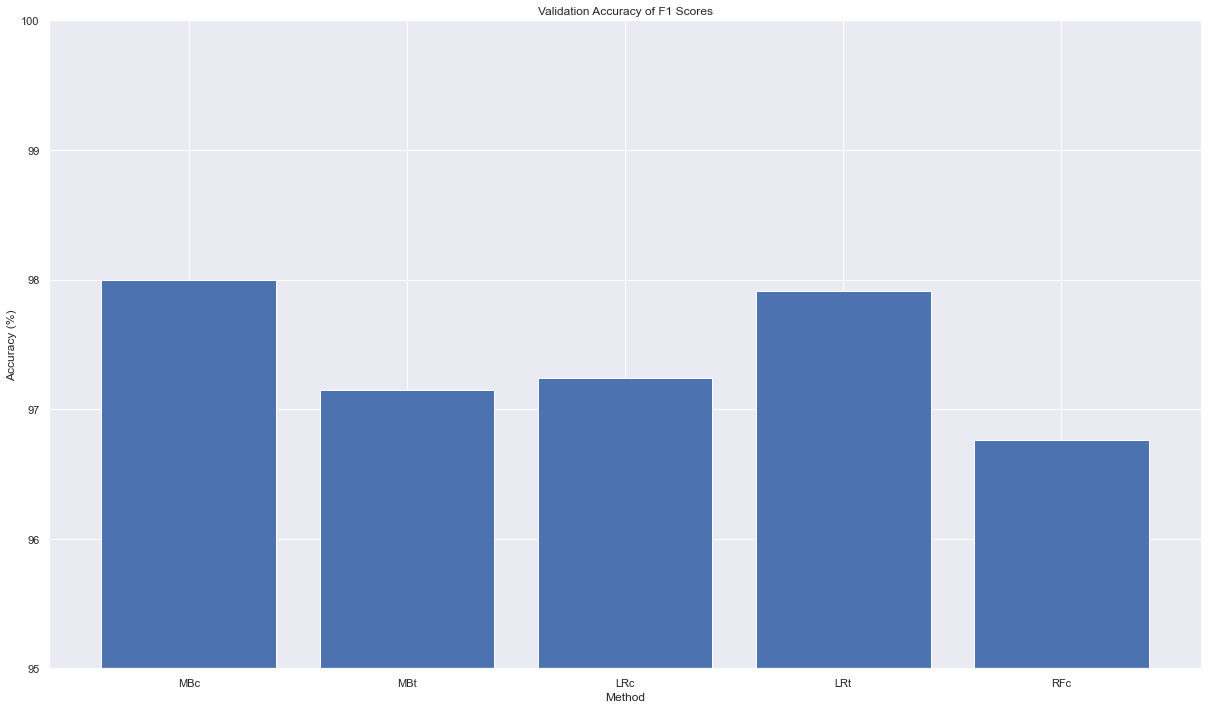

In [85]:
# barplot of accuracy of F1 scores of different models
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set(ylim=(95,100))
langs = ['MBc', 'MBt', 'LRc', 'LRt', 'RFc']
f1score = [98.0,97.15,97.24,97.91,96.76]
ax.bar(langs,f1score)
ax.set_title("Validation Accuracy of F1 Scores")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Method")
plt.show()

In [97]:
#check the test set from the beginning using multinomial naive bayes with countVectorizer whihc performed the best
MB1 = CountVectorizer().fit(X_train_clean)
MB2 = MB1.transform(X_train_clean)
MB3 = MultinomialNB(alpha=0.1)
MB3.fit(MB2,Y_train)
MB4 = MB3.predict(MB2)
MB5 = MB1.transform(X_test_clean)
MB6 = MB3.predict(MB5)

In [98]:
print(classification_report(Y_test, MB6, digits= 4))

              precision    recall  f1-score   support

           0     0.9890    0.9791    0.9840      1098
           1     0.9505    0.9736    0.9619       454

    accuracy                         0.9774      1552
   macro avg     0.9697    0.9763    0.9729      1552
weighted avg     0.9777    0.9774    0.9775      1552



Confusion matrix, without normalization


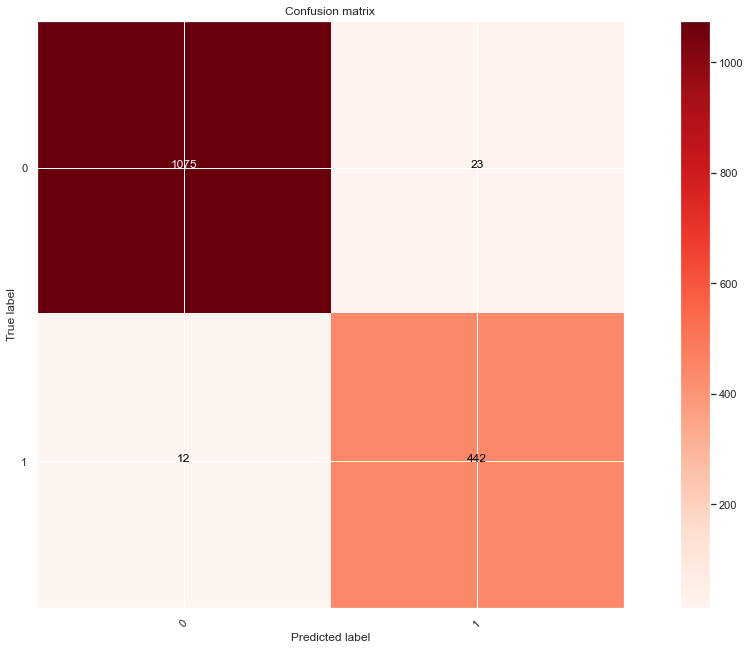

In [100]:
cm = metrics.confusion_matrix(Y_test, MB6, labels=[0,1])
plot_confusion_matrix(cm, classes = [0,1])

In [89]:
pickle.dump(MB3, open('MB_test_CountVec.sav', 'wb'))

Overall 1075 weree correctly classified as non-spam and 442 were classified correctly as spam. 
23 spam non-spam were misclassified as spam, and 12 spam were misclassified as non-spam.
The accuracy of the model was 97.74%.